In [ ]:
# checking paths

import os

def check_file_path(file_path):

    if os.path.isfile(file_path):
        print(f"✅ File exists at: {file_path}")
        print(f"File size: {os.path.getsize(file_path)} bytes")
        return True
    else:
        print(f"❌ File NOT found at: {file_path}")
        return False
train_epi_emb_path = "../../../../../data/embeddings/beta/allele/dimension_1024/padded_train_epitope_embeddings_final.h5"
train_tcr_emb_path = "../../../../../data/embeddings/beta/allele/dimension_1024/padded_train_tcr_embeddings_final.h5"
train_path = "../../../../../data/ba_splitted/train.tsv"
check_file_path(train_path)


✅ File exists at: ../../../../../data/ba_splitted/train.tsv
File size: 19336105 bytes


True

### SHAP Implementation

In [45]:
# v1_mha_1024_res.py

import torch
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, hidden_dim, dropout):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim)
        )

    def forward(self, x):
        return x + self.block(x)

class Classifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout):
        super(Classifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            ResidualBlock(hidden_dim, dropout),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x):
        return self.model(x)

class AttentionBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.1):
        super(AttentionBlock, self).__init__()
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.dropout1 = nn.Dropout(dropout)
        self.ff = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 4),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(embed_dim * 4, embed_dim)
        )
        self.norm2 = nn.LayerNorm(embed_dim)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x, key_padding_mask=None):
        attn_output, _ = self.attn(x, x, x, key_padding_mask=key_padding_mask)
        x = self.norm1(x + self.dropout1(attn_output))
        ff_output = self.ff(x)
        x = self.norm2(x + self.dropout2(ff_output))
        return x

class LazyTCR_Epitope_Dataset(torch.utils.data.Dataset):
    def __init__(self, data_frame, tcr_embeddings, epitope_embeddings):
        """
        Args:
            data_frame (DataFrame): The DataFrame containing sample data.
            tcr_embeddings (h5py.File): HDF5 file containing TCR embeddings.
            epitope_embeddings (h5py.File): HDF5 file containing epitope embeddings.
        """
        self.data_frame = data_frame
        self.tcr_embeddings = tcr_embeddings
        self.epitope_embeddings = epitope_embeddings

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        sample = self.data_frame.iloc[idx]
        tcr_id = sample['TRB_CDR3']  # Column name for TCR IDs
        epitope_id = sample['Epitope']  # Column name for epitope IDs
        label = sample['Binding']  # Target label

        # Access embeddings lazily
        tcr_embedding = self.tcr_embeddings[tcr_id][:]
        epitope_embedding = self.epitope_embeddings[epitope_id][:]

        return (
            torch.tensor(tcr_embedding, dtype=torch.float32),
            torch.tensor(epitope_embedding, dtype=torch.float32),
            torch.tensor(label, dtype=torch.float32),
        )

class TCR_Epitope_Transformer(nn.Module):
    def __init__(self, embed_dim=128, num_heads=4, num_layers=2, max_tcr_length=20, max_epitope_length=15, dropout=0.1, classifier_hidden_dim=64):
        super(TCR_Epitope_Transformer, self).__init__()
        self.embed_dim = embed_dim
        self.tcr_embedding = nn.Linear(1024, embed_dim)
        self.epitope_embedding = nn.Linear(1024, embed_dim)

        self.tcr_bn = nn.BatchNorm1d(max_tcr_length)
        self.epitope_bn = nn.BatchNorm1d(max_epitope_length)

        self.tcr_positional_encoding = nn.Parameter(torch.randn(1, max_tcr_length, embed_dim))
        self.epitope_positional_encoding = nn.Parameter(torch.randn(1, max_epitope_length, embed_dim))

        self.transformer_layers = nn.ModuleList([
            AttentionBlock(embed_dim, num_heads, dropout) for _ in range(num_layers)
        ])

        self.classifier_input_dim = embed_dim * 2  # For concatenated mean+max pooling
        self.classifier = Classifier(self.classifier_input_dim, classifier_hidden_dim, dropout)

    def forward(self, tcr, epitope):
        tcr_emb = self.tcr_embedding(tcr)
        epitope_emb = self.epitope_embedding(epitope)

        # Optional: normalize across sequence
        tcr_emb = self.tcr_bn(tcr_emb)
        epitope_emb = self.epitope_bn(epitope_emb)

        # Create masks
        tcr_mask = (tcr.sum(dim=-1) == 0)
        epitope_mask = (epitope.sum(dim=-1) == 0)

        # Add positional encoding
        tcr_emb += self.tcr_positional_encoding[:, :tcr_emb.size(1), :]
        epitope_emb += self.epitope_positional_encoding[:, :epitope_emb.size(1), :]

        # Concatenate sequence and mask
        combined = torch.cat([tcr_emb, epitope_emb], dim=1)
        key_padding_mask = torch.cat([tcr_mask, epitope_mask], dim=1)

        for layer in self.transformer_layers:
            combined = layer(combined, key_padding_mask=key_padding_mask)

        # Combine mean and max pooling
        pooled_mean = combined.mean(dim=1)
        pooled_max, _ = combined.max(dim=1)
        pooled = torch.cat([pooled_mean, pooled_max], dim=1)

        output = self.classifier(pooled).squeeze(1)
        return output

In [ ]:
import pandas as pd
import h5py
import torch
import numpy as np
import shap
import wandb
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------------- Load Data ----------------

# File paths
train_path = "../../../../../data/splitted_datasets/allele/beta/train.tsv"
train_epi_emb_path = "../../../../../data/embeddings/beta/allele/dimension_1024/padded_train_epitope_embeddings_final.h5"
train_tcr_emb_path = "../../../../../data/embeddings/beta/allele/dimension_1024/padded_train_tcr_embeddings_final.h5"

# Load training data
train_df = pd.read_csv(train_path, sep='\t')

# Select balanced samples
binding_samples = train_df[train_df['Binding'] == 1].sample(25, random_state=42)
non_binding_samples = train_df[train_df['Binding'] == 0].sample(25, random_state=42)
selected_samples = pd.concat([binding_samples, non_binding_samples])

selected_tcrs = selected_samples['TRB_CDR3'].tolist()
selected_epitopes = selected_samples['Epitope'].tolist()

def load_embeddings(h5_path, keys):
    embeddings = []
    with h5py.File(h5_path, 'r') as f:
        for key in keys:
            if key in f:
                embeddings.append(f[key][:])
            else:
                raise ValueError(f"Key '{key}' not found in {h5_path}")
    return np.stack(embeddings)

try:
    tcr_embeddings = load_embeddings(train_tcr_emb_path, selected_tcrs)
    epi_embeddings = load_embeddings(train_epi_emb_path, selected_epitopes)

    tcr_embeddings = torch.from_numpy(tcr_embeddings).float()
    epi_embeddings = torch.from_numpy(epi_embeddings).float()

    dataset = list(zip(tcr_embeddings, epi_embeddings))

    # Prepare background tensors    
    background_tcr = torch.stack([dataset[i][0] for i in range(50)]).to(device)
    background_epitope = torch.stack([dataset[i][1] for i in range(50)]).to(device)

    print(f"Successfully loaded embeddings for {len(dataset)} samples")
    print(f"TCR embeddings shape: {background_tcr.shape}")
    print(f"Epitope embeddings shape: {background_epitope.shape}")

except Exception as e:
    print(f"Error loading embeddings: {str(e)}")

# ---------------- Load Model ----------------

run = wandb.init()
artifact = run.use_artifact('ba_cancerimmunotherapy/dataset-allele/Run_v1_mha_building_SHAPh_model:v2', type='model')
artifact_dir = artifact.download()
# artifact = run.use_artifact('ba_cancerimmunotherapy/dataset-allele/Run_v1_mha_1024h_flattened_model:v2', type='model')



Successfully loaded embeddings for 50 samples
TCR embeddings shape: torch.Size([50, 43, 1024])
Epitope embeddings shape: torch.Size([50, 43, 1024])


wandb:   1 of 1 files downloaded.  


In [47]:
# from your_model_module import TCR_Epitope_Transformer  # Replace with actual import

model = TCR_Epitope_Transformer(
    embed_dim=128, 
    num_heads=8, 
    num_layers=2, 
    max_tcr_length=43, 
    max_epitope_length=43, 
    dropout=0.1
).to(device)

model_file = os.path.join(artifact_dir, os.listdir(artifact_dir)[0])
model.load_state_dict(torch.load(model_file, map_location=device))
model.eval()

# ---------------- Wrap Model for SHAP ----------------

tcr_dim = background_tcr.shape[1]
epitope_dim = background_epitope.shape[1]
class WrappedModel(torch.nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.base_model = base_model

    def forward(self, x):
        tcr = x[:, :tcr_dim]
        epitope = x[:, tcr_dim:]
        output = self.base_model(tcr, epitope)
        return output.unsqueeze(1)  # <- Ensure shape [batch_size, 1]

wrapped_model = WrappedModel(model)

# Prepare SHAP-compatible inputs
background_input = torch.cat([background_tcr, background_epitope], dim=1)
test_tcr = torch.stack([dataset[i][0] for i in range(10)]).to(device)
test_epitope = torch.stack([dataset[i][1] for i in range(10)]).to(device)
test_input = torch.cat([test_tcr, test_epitope], dim=1)

explainer = shap.GradientExplainer(wrapped_model, background_input)
shap_values = explainer.shap_values(test_input)


/tmp/ipykernel_71859/3004346885.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_file, map_location=device))


In [54]:
shap_values.shape

(10, 86, 1024, 1)

### 1. Split SHAP values back into TCR and epitope parts

In [ ]:
shap_vals = shap_values[0].squeeze(-1)  # (86, 1024)

shap_tcr_vals = shap_vals[ :43, :]     
shap_epi_vals = shap_vals[ 43:, :]    # (86, 1024)


In [63]:
shap_tcr_vals.shape
shap_vals.shape

(86, 1024)

### 2. Aggregate across embedding dimension

In [ ]:
tcr_token_scores = shap_tcr_vals.mean(axis=1)  # shape: (43,)
epi_token_scores = shap_epi_vals.mean(axis=1)  # shape: (43,)


In [77]:
tcr_token_scores.shape

(43,)

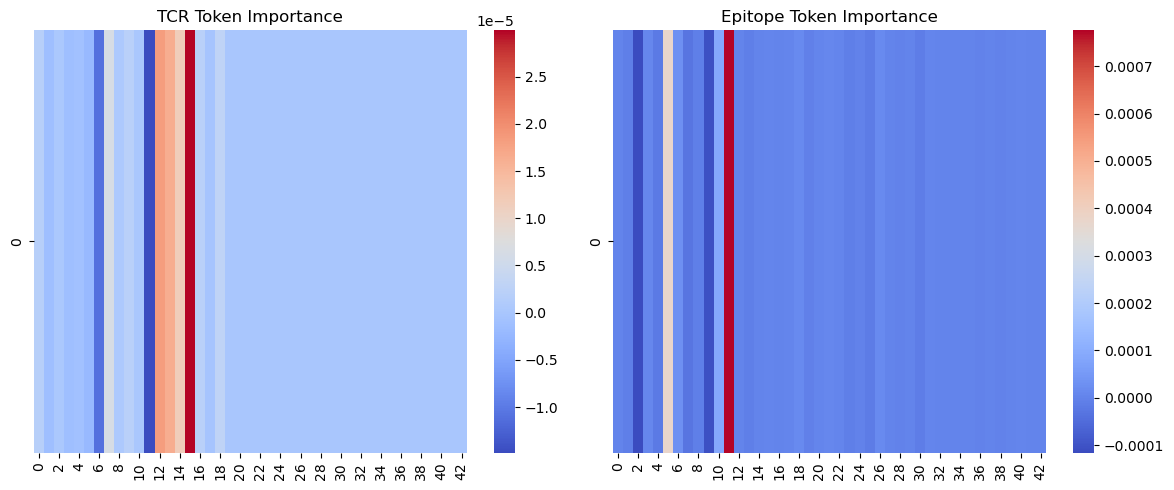

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.heatmap(tcr_token_scores[None, :], cmap="coolwarm", cbar=True)
plt.title("TCR Token Importance")

plt.subplot(1, 2, 2)
sns.heatmap(epi_token_scores[None, :], cmap="coolwarm", cbar=True)
plt.title("Epitope Token Importance")

plt.tight_layout()
plt.show()


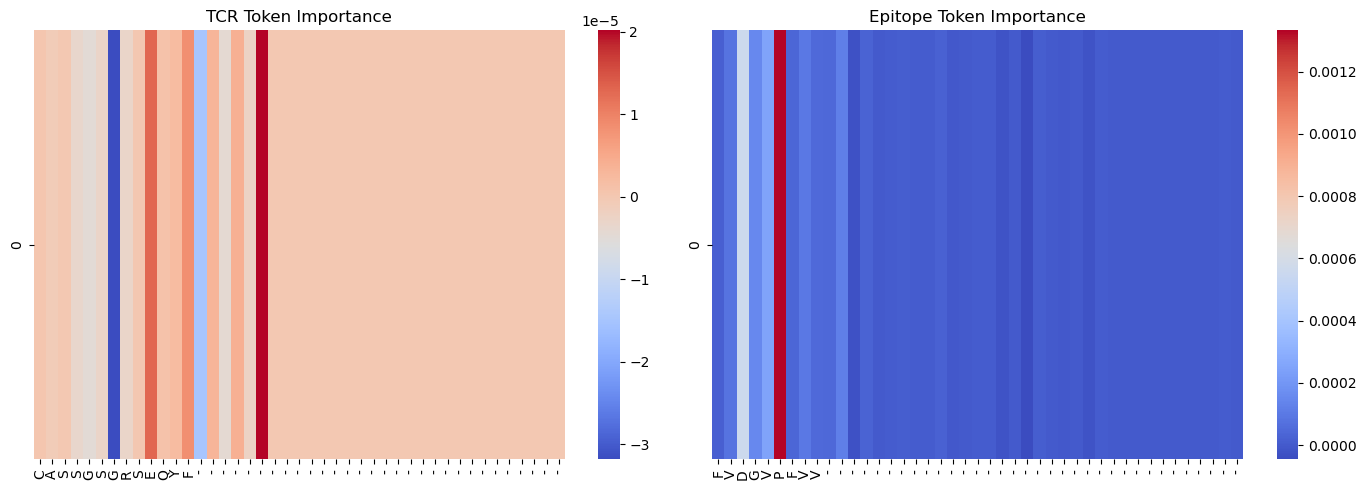

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select sample index
idx = 5

# Get sequence strings for labels
tcr_seq = selected_tcrs[idx]
epitope_seq = selected_epitopes[idx]

# Get SHAP values and squeeze trailing dim
shap_vals = shap_values[idx].squeeze(-1)  # (86, 1024)
shap_tcr_vals = shap_vals[:43, :]
shap_epi_vals = shap_vals[43:, :]

# Compute mean SHAP per token
tcr_token_scores = shap_tcr_vals.mean(axis=1)  # (43,)
epi_token_scores = shap_epi_vals.mean(axis=1)  # (43,)

# Pad labels to match input size (padded to 43)
tcr_labels = list(tcr_seq.ljust(43, '-'))  # pad with '-' if shorter
epi_labels = list(epitope_seq.ljust(43, '-'))

# Plot
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
sns.heatmap(tcr_token_scores[None, :], cmap="coolwarm", cbar=True, xticklabels=tcr_labels)
plt.title("TCR Token Importance")
plt.xticks(rotation=90)

plt.subplot(1, 2, 2)
sns.heatmap(epi_token_scores[None, :], cmap="coolwarm", cbar=True, xticklabels=epi_labels)
plt.title("Epitope Token Importance")
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()


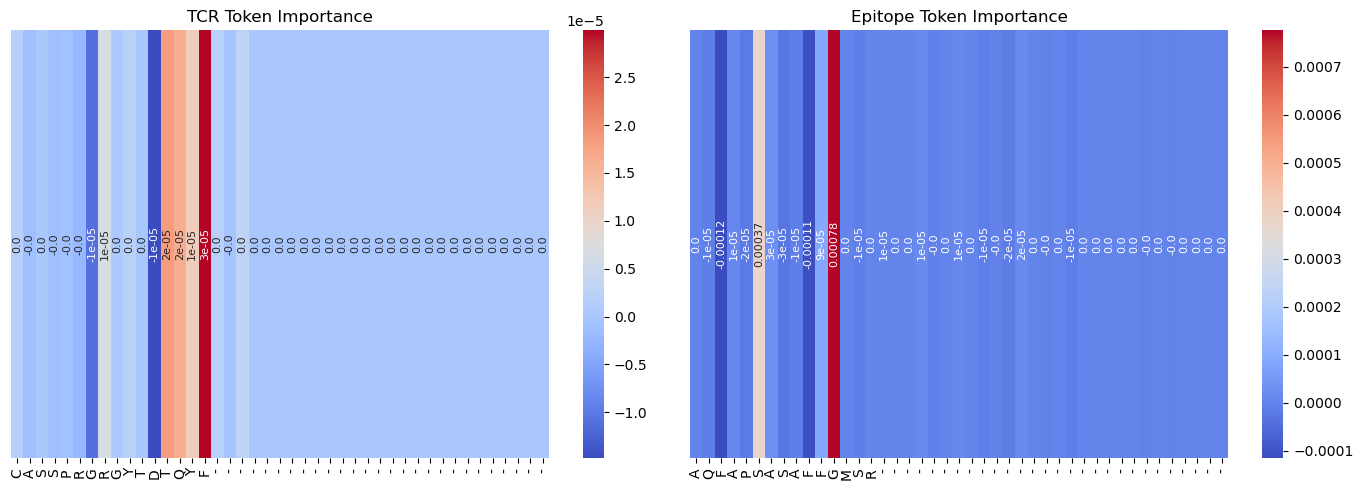

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Select sample index
idx = 0

# Get sequence strings for labels
tcr_seq = selected_tcrs[idx]
epitope_seq = selected_epitopes[idx]

# Get SHAP values and squeeze trailing dim
shap_vals = shap_values[idx].squeeze(-1)  # (86, 1024)
shap_tcr_vals = shap_vals[:43, :]
shap_epi_vals = shap_vals[43:, :]

# Compute mean SHAP per token
tcr_token_scores = shap_tcr_vals.mean(axis=1)  # (43,)
epi_token_scores = shap_epi_vals.mean(axis=1)  # (43,)

# Pad labels to match input size
tcr_labels = list(tcr_seq.ljust(43, '-'))
epi_labels = list(epitope_seq.ljust(43, '-'))

# Reshape for heatmap
tcr_array = tcr_token_scores[None, :]
epi_array = epi_token_scores[None, :]

# Create annotations (round to 3 decimal places)
tcr_annots = np.round(tcr_array, 5).astype(str)
epi_annots = np.round(epi_array, 5).astype(str)

# Plot with annotations
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
sns.heatmap(tcr_array, cmap="coolwarm", cbar=True, xticklabels=tcr_labels,
            annot=tcr_annots, fmt="", annot_kws={"size": 8, "rotation": 90})
plt.title("TCR Token Importance")
plt.xticks(rotation=90)
plt.yticks([])

plt.subplot(1, 2, 2)
sns.heatmap(epi_array, cmap="coolwarm", cbar=True, xticklabels=epi_labels,
            annot=epi_annots, fmt="", annot_kws={"size": 8, "rotation": 90})
plt.title("Epitope Token Importance")
plt.xticks(rotation=90)
plt.yticks([])

plt.tight_layout()
plt.show()


### SHAP on Run_v1_mha_1024_shap_model:v0

In [ ]:
import torch
import torch.nn as nn

import pandas as pd
import h5py
import torch
import numpy as np
import shap
import wandb
import os

# class ResidualBlock(nn.Module):
#     def __init__(self, hidden_dim, dropout):
#         super(ResidualBlock, self).__init__()
#         self.block = nn.Sequential(
#             nn.BatchNorm1d(hidden_dim),
#             nn.ReLU(),
#             nn.Linear(hidden_dim, hidden_dim),
#             nn.BatchNorm1d(hidden_dim),
#             nn.ReLU(),
#             nn.Dropout(dropout),
#             nn.Linear(hidden_dim, hidden_dim)
#         )
class ResidualBlock(nn.Module):
    def __init__(self, hidden_dim, dropout):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim)
        )

    def forward(self, x):
        return x + self.block(x)

class Classifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout):
        super(Classifier, self).__init__()
        self.model = nn.Sequential(
            ResidualBlock(input_dim, dropout),
            nn.Linear(input_dim, 1)
        )

    def forward(self, x):
        return self.model(x)

class AttentionBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.1):
        super(AttentionBlock, self).__init__()
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.dropout1 = nn.Dropout(dropout)
        self.ff = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 4),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(embed_dim * 4, embed_dim)
        )
        self.norm2 = nn.LayerNorm(embed_dim)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x, key_padding_mask=None):
        attn_output, _ = self.attn(x, x, x, key_padding_mask=key_padding_mask)
        x = self.norm1(x + self.dropout1(attn_output))
        ff_output = self.ff(x)
        x = self.norm2(x + self.dropout2(ff_output))
        return x

class LazyTCR_Epitope_Dataset(torch.utils.data.Dataset):
    def __init__(self, data_frame, tcr_embeddings, epitope_embeddings):
        """
        Args:
            data_frame (DataFrame): The DataFrame containing sample data.
            tcr_embeddings (h5py.File): HDF5 file containing TCR embeddings.
            epitope_embeddings (h5py.File): HDF5 file containing epitope embeddings.
        """
        self.data_frame = data_frame
        self.tcr_embeddings = tcr_embeddings
        self.epitope_embeddings = epitope_embeddings

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        sample = self.data_frame.iloc[idx]
        tcr_id = sample['TRB_CDR3']  # Column name for TCR IDs
        epitope_id = sample['Epitope']  # Column name for epitope IDs
        label = sample['Binding']  # Target label

        # Access embeddings lazily
        tcr_embedding = self.tcr_embeddings[tcr_id][:]
        epitope_embedding = self.epitope_embeddings[epitope_id][:]

        return (
            torch.tensor(tcr_embedding, dtype=torch.float32),
            torch.tensor(epitope_embedding, dtype=torch.float32),
            torch.tensor(label, dtype=torch.float32),
        )

class TCR_Epitope_Transformer(nn.Module):
    def __init__(self, embed_dim=128, num_heads=4, num_layers=2, max_tcr_length=43, 
    max_epitope_length=43, dropout=0.1, classifier_hidden_dim=64):
        super(TCR_Epitope_Transformer, self).__init__()
        self.embed_dim = embed_dim
        self.tcr_embedding = nn.Linear(1024, embed_dim)
        self.epitope_embedding = nn.Linear(1024, embed_dim)

        self.tcr_positional_encoding = nn.Parameter(torch.randn(1, max_tcr_length, embed_dim))
        self.epitope_positional_encoding = nn.Parameter(torch.randn(1, max_epitope_length, embed_dim))

        self.transformer_layers = nn.ModuleList([
            AttentionBlock(embed_dim, num_heads, dropout) for _ in range(num_layers)
        ])
        self.classifier_input_dim = (max_tcr_length + max_epitope_length) * embed_dim

        self.classifier = Classifier(self.classifier_input_dim, classifier_hidden_dim, dropout)

    def forward(self, tcr, epitope):
        tcr_emb = self.tcr_embedding(tcr)
        epitope_emb = self.epitope_embedding(epitope)

        # Create masks
        tcr_mask = (tcr.sum(dim=-1) == 0)
        epitope_mask = (epitope.sum(dim=-1) == 0)

        # Add positional encoding
        tcr_emb += self.tcr_positional_encoding[:, :tcr_emb.size(1), :]
        epitope_emb += self.epitope_positional_encoding[:, :epitope_emb.size(1), :]

        # Concatenate sequence and mask
        combined = torch.cat([tcr_emb, epitope_emb], dim=1)
        key_padding_mask = torch.cat([tcr_mask, epitope_mask], dim=1)

        for layer in self.transformer_layers:
            combined = layer(combined, key_padding_mask=key_padding_mask)

        flattened = combined.view(combined.size(0), -1)  

        output = self.classifier(flattened).squeeze(1)
        return output

In [11]:

# ---------------- Load Data ----------------

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_path = "../../../../../data/splitted_datasets/allele/beta/train.tsv"
train_epi_emb_path = "../../../../../data/embeddings/beta/allele/dimension_1024/padded_train_epitope_embeddings_final.h5"
train_tcr_emb_path = "../../../../../data/embeddings/beta/allele/dimension_1024/padded_train_tcr_embeddings_final.h5"

train_df = pd.read_csv(train_path, sep='\t')
binding_samples = train_df[train_df['Binding'] == 1].sample(100, random_state=42)
non_binding_samples = train_df[train_df['Binding'] == 0].sample(50, random_state=42)
selected_samples = pd.concat([binding_samples, non_binding_samples])
selected_tcrs = selected_samples['TRB_CDR3'].tolist()
selected_epitopes = selected_samples['Epitope'].tolist()

def load_embeddings(h5_path, keys):
    embeddings = []
    with h5py.File(h5_path, 'r') as f:
        for key in keys:
            if key in f:
                embeddings.append(f[key][:])
            else:
                raise ValueError(f"Key '{key}' not found in {h5_path}")
    return np.stack(embeddings)

tcr_embeddings = load_embeddings(train_tcr_emb_path, selected_tcrs)
epi_embeddings = load_embeddings(train_epi_emb_path, selected_epitopes)
# tcr_embeddings = torch.from_numpy(tcr_embeddings).float()
# epi_embeddings = torch.from_numpy(epi_embeddings).float()

class InMemoryTCR_Epitope_Dataset(torch.utils.data.Dataset):
    def __init__(self, data_frame, tcr_embeddings, epitope_embeddings):
        self.data_frame = data_frame.reset_index(drop=True)
        self.tcr_embeddings = tcr_embeddings
        self.epitope_embeddings = epitope_embeddings

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        sample = self.data_frame.iloc[idx]
        return (
            torch.tensor(self.tcr_embeddings[idx], dtype=torch.float32),
            torch.tensor(self.epitope_embeddings[idx], dtype=torch.float32),
            torch.tensor(sample['Binding'], dtype=torch.float32),
        )
dataset = InMemoryTCR_Epitope_Dataset(selected_samples, tcr_embeddings, epi_embeddings)


# ---------------- adjustment ------------------


# # Create dataset
# dataset = LazyTCR_Epitope_Dataset(train_df, tcr_embeddings, epi_embeddings)

# # Optional: create a DataLoader
# batch_size = 128
# dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Quick sanity check
sample_tcr, sample_epitope, sample_label = dataset[0]
print("TCR Embedding shape:", sample_tcr.shape)
print("Epitope Embedding shape:", sample_epitope.shape)
print("Label:", sample_label)

# ------------------- until here -----------------

# dataset = list(zip(tcr_embeddings, epi_embeddings))

# background_tcr = torch.stack([dataset[i][0] for i in range(50)]).to(device)
# background_epitope = torch.stack([dataset[i][1] for i in range(50)]).to(device)

# ---------------- Load Model ---------------- to be updated!!!

run = wandb.init()
artifact = run.use_artifact('ba_cancerimmunotherapy/dataset-allele/Run_v1_mha_1024_shap_model:v0', type='model')
artifact_dir = artifact.download()
model_file = os.path.join(artifact_dir, os.listdir(artifact_dir)[0])

TCR Embedding shape: torch.Size([43, 1024])
Epitope Embedding shape: torch.Size([43, 1024])
Label: tensor(1.)


wandb: Downloading large artifact Run_v1_mha_1024_shap_model:v0, 926.60MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.7


In [12]:
model = TCR_Epitope_Transformer(
    embed_dim=128, 
    num_heads=4, 
    num_layers=1, 
    dropout=0.125, 
    max_tcr_length=43, 
    max_epitope_length=43, 
    classifier_hidden_dim=64
).to(device)
model.load_state_dict(torch.load(model_file, map_location=device))
model.eval()


/tmp/ipykernel_119307/974845466.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_file, map_location=device))


TCR_Epitope_Transformer(
  (tcr_embedding): Linear(in_features=1024, out_features=128, bias=True)
  (epitope_embedding): Linear(in_features=1024, out_features=128, bias=True)
  (transformer_layers): ModuleList(
    (0): AttentionBlock(
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
      )
      (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.125, inplace=False)
      (ff): Sequential(
        (0): Linear(in_features=128, out_features=512, bias=True)
        (1): ReLU()
        (2): Dropout(p=0.125, inplace=False)
        (3): Linear(in_features=512, out_features=128, bias=True)
      )
      (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout2): Dropout(p=0.125, inplace=False)
    )
  )
  (classifier): Classifier(
    (model): Sequential(
      (0): ResidualBlock(
        (block): Sequential(
          (0): LayerNorm((11008,), eps=

In [13]:
import shap
import torch
import numpy as np

# # Ensure the model is in eval mode
# model.eval()

# Wrap the model with a lambda to only return the output before sigmoid/logit
f_model = lambda tcr, epitope: model(tcr, epitope).detach().cpu().numpy()

# Select a representative background set and samples to explain
def get_batch(dataset, indices):
    tcr_batch, epitope_batch, label_batch = [], [], []
    for idx in indices:
        tcr, epitope, label = dataset[idx]
        tcr_batch.append(tcr)
        epitope_batch.append(epitope)
        label_batch.append(label)
    return (
        torch.stack(tcr_batch).to(device),
        torch.stack(epitope_batch).to(device),
        torch.tensor(label_batch)
    )

# ⚠️ Adjust according to your setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset: assumed to be an instance of LazyTCR_Epitope_Dataset
background_idxs = np.random.choice(len(dataset), size=100, replace=False)
explained_idxs = np.random.choice(len(dataset), size=50, replace=False)

background_tcr, background_epitope, _ = get_batch(dataset, background_idxs)
explain_tcr, explain_epitope, explain_labels = get_batch(dataset, explained_idxs)

# Define a wrapper compatible with SHAP DeepExplainer

class SHAPWrapper(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, *inputs):
        # SHAP passes each input tensor as a separate arg
        return self.model(*inputs)

wrapped_model = SHAPWrapper(model)

# SHAP expects input as tuple if model takes multiple tensors
explainer = shap.DeepExplainer(wrapped_model, [background_tcr, background_epitope])
shap_values = explainer.shap_values([explain_tcr, explain_epitope])
tcr_flat = explain_tcr.view(explain_tcr.size(0), -1).cpu().numpy()
epi_flat = explain_epitope.view(explain_epitope.size(0), -1).cpu().numpy()

shap.summary_plot(
    shap_values[0],
    features=np.concatenate([tcr_flat, epi_flat], axis=1),
    feature_names=[f"TCR_{i}" for i in range(tcr_flat.shape[1])] + [f"EPI_{i}" for i in range(epi_flat.shape[1])]
)

# # Plotting
# shap.summary_plot(shap_values[0], features=np.concatenate([explain_tcr.cpu().numpy(), explain_epitope.cpu().numpy()], axis=1), feature_names=[f"TCR_{i}" for i in range(1024)] + [f"EPI_{i}" for i in range(1024)])


RuntimeError: Output 0 of BackwardHookFunctionBackward is a view and is being modified inplace. This view was created inside a custom Function (or because an input was returned as-is) and the autograd logic to handle view+inplace would override the custom backward associated with the custom Function, leading to incorrect gradients. This behavior is forbidden. You can fix this by cloning the output of the custom Function.

In [ ]:

# ---------------- SHAP Wrapper ----------------

tcr_dim = background_tcr.shape[1]
epitope_dim = background_epitope.shape[1]

class WrappedModel(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.base_model = base_model

    def forward(self, x):
        tcr = x[:, :tcr_dim]
        epitope = x[:, tcr_dim:]
        return self.base_model(tcr, epitope).unsqueeze(1)

wrapped_model = WrappedModel(model)

background_input = torch.cat([background_tcr, background_epitope], dim=1)
test_tcr = torch.stack([dataset[i][0] for i in range(10)]).to(device)
test_epitope = torch.stack([dataset[i][1] for i in range(10)]).to(device)
test_input = torch.cat([test_tcr, test_epitope], dim=1)

explainer = shap.GradientExplainer(wrapped_model, background_input)
shap_values = explainer.shap_values(test_input)

print("SHAP analysis complete. Shape:", np.array(shap_values).shape)


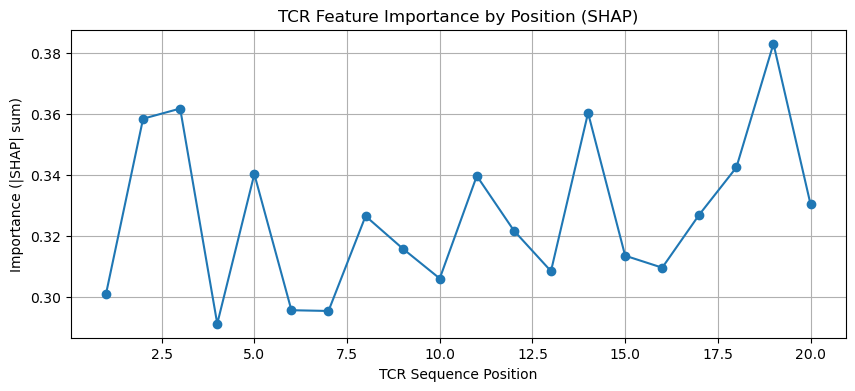

In [37]:
# # Reshape to (batch_size, sequence_length, embedding_dim)
# tcr_shap_values = tcr_shap.reshape(1, 20, 128)  # shape: (1, 20, 128)

# # Aggregate importance by TCR position
# tcr_importance_per_pos = tcr_shap_values.abs().sum(dim=2).squeeze(0)  # (20,)

# Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
plt.plot(range(1, 21), tcr_importance_per_pos.cpu().numpy(), marker='o')
plt.title("TCR Feature Importance by Position (SHAP)")
plt.xlabel("TCR Sequence Position")
plt.ylabel("Importance (|SHAP| sum)")
plt.grid(True)
plt.show()


In [38]:
# Your decoded sequences
tcr_aa_sequence = "CASSFGQRDRGYWRNTEAFF"   # Length = 20
epitope_aa_sequence = "ARNLVPMVATVQGQN"  # Length = 15


In [39]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from IPython.display import display, HTML

def color_sequence_by_importance(sequence, importances, cmap_name="Reds"):
    """
    Returns an HTML string with amino acids colored by importance values.
    """
    cmap = cm.get_cmap(cmap_name)
    norm = mcolors.Normalize(vmin=0, vmax=max(importances))
    
    html_str = ""
    for aa, score in zip(sequence, importances):
        rgba = cmap(norm(score))
        color = mcolors.to_hex(rgba)
        html_str += f'<span style="background-color:{color};padding:2px;">{aa}</span>'
    
    return html_str


In [41]:
# Example usage
tcr_html = color_sequence_by_importance(tcr_aa_sequence, tcr_importance_per_pos)
# epitope_html = color_sequence_by_importance(epitope_aa_sequence, epitope_importance_per_pos)

# Display in notebook
display(HTML(f"<h4>TCR Sequence SHAP Overlay</h4>{tcr_html}"))
# display(HTML(f"<h4>Epitope Sequence SHAP Overlay</h4>{epitope_html}"))


/tmp/ipykernel_20749/4162379589.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name)


In [ ]:
import shap
import torch

class CustomModelWrapper(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, inputs):
        # Unpack tuple to pass to the original model
        return self.model(*inputs)
        
wrapped_model = CustomModelWrapper(model)


In [8]:
# explainer = shap.GradientExplainer(wrapped_model, explainer_input)
# # Or use DeepExplainer if all ops are supported
# # explainer = shap.DeepExplainer(wrapped_model, explainer_input)

explainer = shap.Explainer(wrapped_model, explainer_input)


In [9]:
sample_input = (
    tcr[0:1],
    epitope[0:1],
    trbv[0:1],
    trbj[0:1],
    mhc[0:1]
)

shap_values = explainer(sample_input)


ValueError: max_evals=500 is too low for the Permutation explainer, it must be at least 2 * num_features + 1 = 40961!

In [ ]:
# # Flatten the feature input as needed (e.g., combined_features shape)
# # Visualize one component (e.g., total importance)
# shap_values_tensor = torch.cat([v.reshape(1, -1) for v in shap_values], dim=1)
# shap.summary_plot(shap_values_tensor.detach().numpy())

shap.plots.waterfall(shap_values[0][0])  # 0 = tcr embedding SHAP, second 0 = first sample

